##Notebook 3 : Finetuning Al-BERT

This series of notebooks demonstrates a comparative approach to fake news detection using natural language processing (NLP) techniques. We will use a dataset from Kaggle containing labeled news articles as real or fake.

**Authored by @ Divye Joshi, School of Engineering, JNU**

### Ensuring TensorFlow Version 2.15
This code installs TensorFlow version 2.15.0 and tensorflow-text 2.15.0 using pip. This specific version might be required for compatibility with the code in this notebook. Errors during installation can be ignored.

In [ ]:
!pip -q install tensorflow==2.15.0
!pip -q install tensorflow-text==2.15.0

### Importing Necessary Libraries
This code imports the required libraries for data processing, model building, and visualization.

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_text as text
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint,EarlyStopping

import gdown
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


### Downloading the Preprocessed Dataset
This Code downloads the preprocessed dataset using `gdown`. The dataset is assumed to be processed in a previous notebook and is stored in a Google Drive file.

In [ ]:
gdown.download("https://drive.google.com/file/d/1jlTBJmg5eOVnK0VWWMf4sqMko-LrRkth/view?usp=sharing",fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1jlTBJmg5eOVnK0VWWMf4sqMko-LrRkth
From (redirected): https://drive.google.com/uc?id=1jlTBJmg5eOVnK0VWWMf4sqMko-LrRkth&confirm=t&uuid=c381261d-b21d-4439-8c15-cf0dc396e0cb
To: /content/data.npz
100%|██████████| 55.7M/55.7M [00:00<00:00, 69.9MB/s]


'data.npz'

### Loading Features and Labels
This code loads the features and labels from the downloaded dataset file (`data.npz`).  `features` likely contains the text data, and `labels` contains the corresponding target variables (e.g., sentiment labels).

In [ ]:
loaded_data = np.load("data.npz")
features=loaded_data["features"]
labels=loaded_data["labels"]

### Splitting and Shuffling the Dataset

This code splits the dataset into training and testing sets using `train_test_split` and then shuffles both sets using `shuffle` to ensure randomness.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.2)
x_train, y_train = shuffle(x_train,y_train, random_state=42)
x_test, y_test = shuffle(x_test,y_test, random_state=42)

### Loading Pre-trained ALBERT Layers

This code loads the ALBERT preprocessor and encoder from TensorFlow Hub. These layers will be used for text preprocessing and feature extraction.

In [ ]:
albert_preprocess = hub.KerasLayer( "http://tfhub.dev/tensorflow/albert_en_preprocess/3")
albert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

### Building the Model

This code defines the model architecture using the Keras functional API. It includes an input layer, preprocessing, encoding, and dense layers for classification.

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string,)
preprocessed_text = albert_preprocess(text_input)
encoded_text = albert_encoder(preprocessed_text)

Layer = tf.keras.layers.Dense(16, activation='relu')(encoded_text['pooled_output'])
Layer = tf.keras.layers.Dense(1, activation='sigmoid')(Layer)

model = tf.keras.Model(inputs=[text_input], outputs = [Layer])

### Model Summary

This Code prints a summary of the model, showing the layers, output shapes, and the number of parameters.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

### Defining Callbacks

This Code defines callbacks for early stopping and model checkpointing to monitor the training process and save the best model.

In [ ]:
Earstop=EarlyStopping(monitor='val_accuracy',patience=5)
checkP=ModelCheckpoint('fintuned-albert_model.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

### Compiling the Model

This Code compiles the model, specifying the optimizer, loss function, and metrics for evaluation.

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Training the Model

This Code trains the model using the training data and evaluates it on the validation data. It also utilizes the defined callbacks.

In [ ]:
history=model.fit(x_train,y_train,epochs=5,verbose=1,validation_data=(x_test,y_test),callbacks=[checkP,Earstop])

Epoch 1/5
139/140 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9834
Epoch 1: val_accuracy improved from 0.98203 to 0.99012, saving model to fintuned-albert_model.h5
140/140 [==============================] - 69s 495ms/step - loss: 0.0534 - accuracy: 0.9834 - val_loss: 0.0315 - val_accuracy: 0.9901
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/140 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9847
Epoch 2: val_accuracy improved from 0.99012 to 0.99281, saving model to fintuned-albert_model.h5
140/140 [==============================] - 68s 487ms/step - loss: 0.0480 - accuracy: 0.9847 - val_loss: 0.0255 - val_accuracy: 0.9928
Epoch 3/5
139/140 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9872
Epoch 3: val_accuracy did not improve from 0.99281
140/140 [==============================] - 68s 485ms/step - loss: 0.0442 - accuracy: 0.9872 - val_loss: 0.0218 - val_accuracy: 0.9928
Epoch 4/5
139/140 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9854
Epoch 4: val_accuracy improved from 0.99281 to 0.99641, saving model to fintuned-albert_model.h5
140/140 [==============================] - 68s 484ms/step - loss: 0.0413 - accuracy: 0.9854 - val_loss: 0.0183 - val_accuracy: 0.9964
Epoch 5/5
139/140 [============================>.] - ETA: 0s - loss: 0.0331 - 

### Visualizing Training Results

This Code plots the training and validation accuracy and loss curves to visualize the model's performance during training.

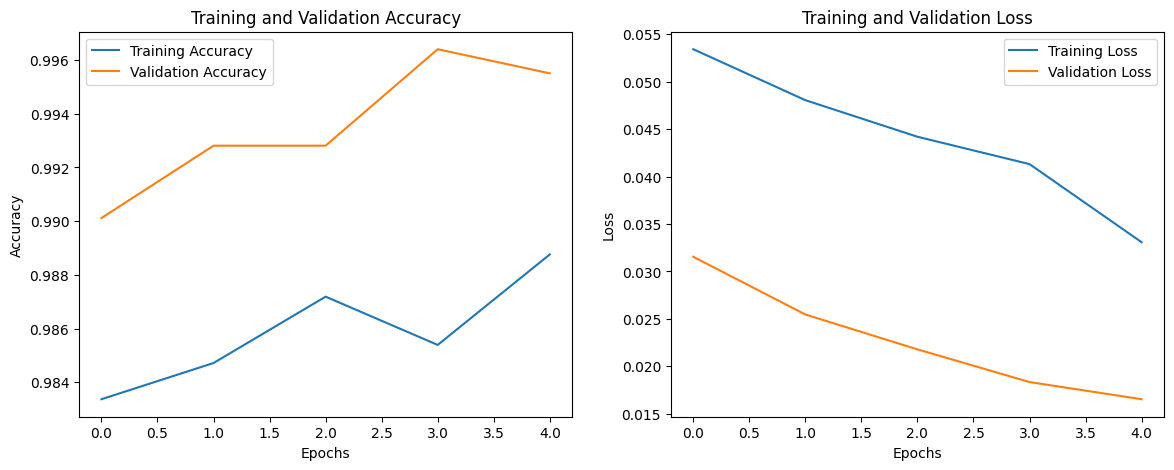

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()